###Основная часть

In [1]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer

In [2]:
def get_grad(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
    linear_model = np.dot(X, w) + w0
    prob = 1 / (1 + np.exp(y * linear_model))
    grad_w = -(X.T @ (y * prob)) / len(y) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -np.sum(y * prob) / len(y)
    return grad_w, grad_w0

In [3]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-8-1d2cba334443>:25: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(y * linear_model))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

KNN Model Accuracy: 0.8558333333333333
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1232
           1       0.99      0.96      0.98      1174
           2       0.74      0.82      0.78      1200
           3       0.90      0.87      0.88      1242
           4       0.78      0.76      0.77      1185
           5       0.99      0.83      0.91      1141
           6       0.66      0.56      0.61      1243
           7       0.89      0.96      0.92      1224
           8       0.98      0.95      0.97      1149
           9       0.91      0.97      0.94      1210

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.85     12000

Logistic Regression Model Accuracy: 0.8375833333333333
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0

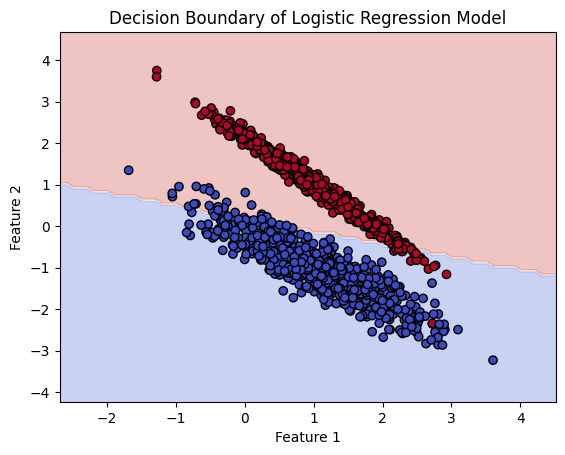

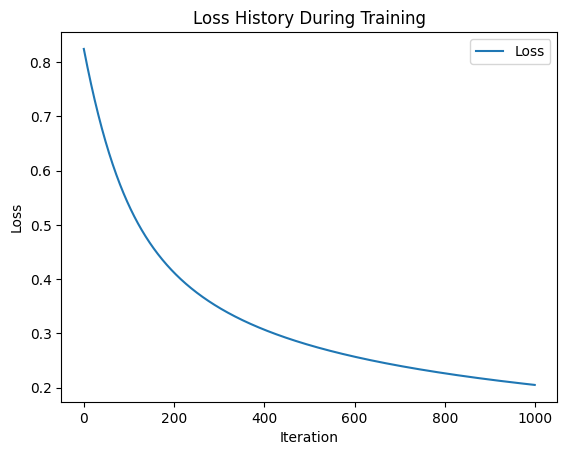

In [ ]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer

# Функция расчета функции потерь для логистической регрессии с регуляризацией Elastic Net
def loss(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> float:
    linear_model = np.dot(X, w) + w0
    log_loss = np.log(1 + np.exp(-y * linear_model)).mean()
    l1_penalty = gamma * np.abs(w).sum()
    l2_penalty = beta * np.sum(w ** 2)
    total_loss = log_loss + l1_penalty + l2_penalty
    return total_loss

# Функция расчета градиента для логистической регрессии с регуляризацией Elastic Net
def get_grad(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
    linear_model = np.dot(X, w) + w0
    prob = 1 / (1 + np.exp(y * linear_model))
    grad_w = -(X.T @ (y * prob)) / len(y) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -np.sum(y * prob) / len(y)
    return grad_w, grad_w0

# Класс логистической регрессии, обучающийся методом SGD и сохраняющий историю потерь
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.w0 = 0.0

        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            w_update = self.lr * grad_w
            w0_update = self.lr * grad_w0
            self.w -= w_update
            self.w0 -= w0_update
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)
            if np.linalg.norm(w_update) < self.tolerance and abs(w0_update) < self.tolerance:
                break

    def predict(self, X):
        linear_model = np.dot(X, self.w) + self.w0
        return (linear_model >= 0).astype(int)

    def predict_proba(self, X):
        linear_model = np.dot(X, self.w) + self.w0
        probabilities = 1 / (1 + np.exp(-linear_model))
        return np.vstack([1 - probabilities, probabilities]).T

# Функция для отрисовки объектов, их меток и разделяющей гиперплоскости
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary of Logistic Regression Model")
    plt.show()


# Загрузка и подготовка данных
data = pd.read_csv('train.csv')
X = data.drop(columns=['Id', 'Category']).values
y = data['Category'].values

# Удаление строк с NaN значениями в X и y
not_nan_indices = ~np.isnan(y)
X = X[not_nan_indices]
y = y[not_nan_indices]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Заполнение NaN значений в X средними значениями по столбцам
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Обучение и оценка модели KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_report = classification_report(y_test, knn_predictions)

# Обучение и оценка модели логистической регрессии
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
log_reg_report = classification_report(y_test, log_reg_predictions)

# Обучение и оценка кастомной логистической регрессии
custom_logit_model = Logit(beta=1.0, gamma=1.0, lr=1e-2, max_iter=1000)
custom_logit_model.fit(X_train, y_train)
custom_logit_predictions = custom_logit_model.predict(X_test)
custom_logit_accuracy = accuracy_score(y_test, custom_logit_predictions)
custom_logit_report = classification_report(y_test, custom_logit_predictions)

# Вывод результатов
print("KNN Model Accuracy:", knn_accuracy)
print("KNN Classification Report:\n", knn_report)
print("Logistic Regression Model Accuracy:", log_reg_accuracy)
print("Logistic Regression Classification Report:\n", log_reg_report)
print("Custom Logistic Regression Model Accuracy:", custom_logit_accuracy)
print("Custom Logistic Regression Classification Report:\n", custom_logit_report)

# Генерация данных и приведение меток к -1 и 1
from sklearn.datasets import make_classification
X_vis, y_vis = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                                   random_state=42, n_clusters_per_class=1)
y_vis[y_vis == 0] = -1  # Преобразование меток 0 в -1

# Обучение модели Logit для визуализации разделяющей гиперплоскости
model_vis = Logit(beta=0, gamma=0)
model_vis.fit(X_vis, y_vis)

# Отрисовка разделяющей гиперплоскости
plot_decision_boundary(model_vis, X_vis, y_vis)

# Отображение истории функции потерь
plot_loss_history(model_vis)


### Практическая часть

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


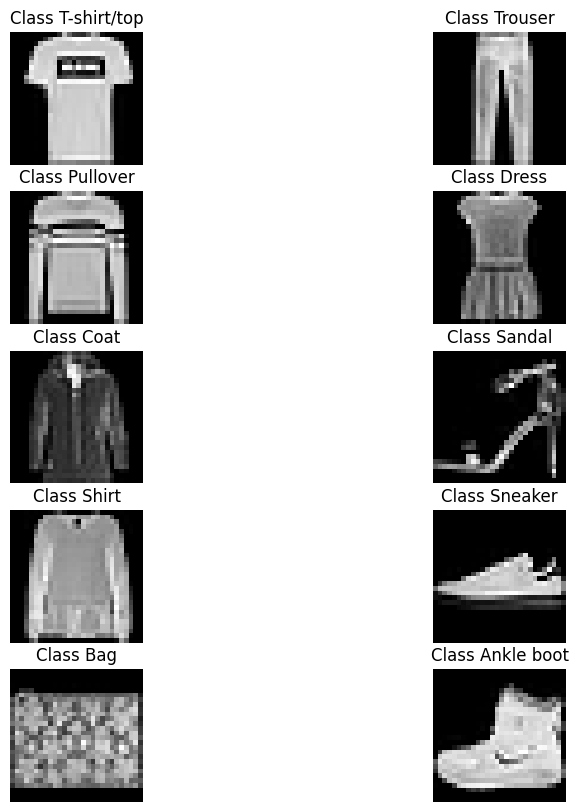

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KNN Accuracy: 0.8220
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       200
           1       0.99      0.95      0.97       203
           2       0.76      0.73      0.74       214
           3       0.86      0.83      0.84       190
           4       0.73      0.74      0.74       219
           5       0.99      0.75      0.86       195
           6       0.54      0.62      0.58       197
           7       0.83      0.95      0.89       200
           8       0.97      0.90      0.93       194
           9       0.88      0.97      0.92       188

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.83      2000
weighted avg       0.83      0.82      0.82      2000

Logistic Regression Accuracy: 0.8500
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81       200
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform

# 1. Импортируем датасет Fashion MNIST из TensorFlow и делим его на train и test
(X_train_full, y_train_full), (X_test_full, y_test_full) = tf.keras.datasets.fashion_mnist.load_data()

# Уменьшаем объем данных для ускорения подбора гиперпараметров
X_train, X_test, y_train, y_test = X_train_full[:10000], X_test_full[:2000], y_train_full[:10000], y_test_full[:2000]
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 2. Визуализируем по одному представителю каждого класса
def plot_class_representatives(X, y, class_labels):
    plt.figure(figsize=(10, 10))
    for class_id in np.unique(y):
        idx = np.where(y == class_id)[0][0]
        plt.subplot(5, 2, class_id + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Class {class_labels[class_id]}')
        plt.axis('off')
    plt.show()

class_labels = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

plot_class_representatives(X_train, y_train, class_labels)

# 3. Нормализация данных (используем только StandardScaler для оптимизации)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# 4. Подбор гиперпараметров и обучение моделей с использованием RandomizedSearchCV

# Параметры для KNeighborsClassifier
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Параметры для LogisticRegression
logreg_params = {
    'penalty': ['l2'],   # Ограничиваем для ускорения
    'C': uniform(loc=0.01, scale=10),  # Параметр регуляризации
    'solver': ['saga'],   # Оптимизированный для больших данных
    'max_iter': [100]     # Ограничение количества итераций
}

# RandomizedSearchCV для KNeighborsClassifier
knn = KNeighborsClassifier()
random_knn = RandomizedSearchCV(knn, knn_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, n_iter=5)
random_knn.fit(X_train_standard, y_train)
best_knn = random_knn.best_estimator_

# RandomizedSearchCV для LogisticRegression
logreg = LogisticRegression()
random_logreg = RandomizedSearchCV(logreg, logreg_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, n_iter=5)
random_logreg.fit(X_train_standard, y_train)
best_logreg = random_logreg.best_estimator_

# 5. Оценка моделей на тестовом наборе данных
y_pred_knn = best_knn.predict(X_test_standard)
y_pred_logreg = best_logreg.predict(X_test_standard)

# Метрики для KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Метрики для Logistic Regression
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Сравнение моделей
print("Лучшие параметры для KNN:", random_knn.best_params_)
print("Лучшие параметры для Logistic Regression:", random_logreg.best_params_)
print("Logistic Regression показала лучшее качество на тестовых данных." if accuracy_logreg > accuracy_knn else "KNN показала лучшее качество на тестовых данных.")


### Задачи
---
Задача 1
---
Если у нас есть датасет с 10,000 объектов, где все признаки для каждого объекта одинаковы, то для логистической регрессии это означает, что она не сможет эффективно разделить классы. Логистическая регрессия опирается на различия в признаках, чтобы найти разделяющую гиперплоскость между классами. Поскольку признаки одинаковы, модель не сможет отличить положительные примеры от отрицательных, что приведет к нескольким последствиям:

Отсутствие полезной информации: Поскольку признаки одинаковы, логистическая регрессия не сможет найти какой-либо разделяющий гиперплоскости, так как у объектов нет отличительных признаков.

Плохая сходимость в методе SGD: Поскольку градиенты будут одинаковыми для всех объектов, оптимизатор не сможет направить веса в правильное направление для минимизации функции потерь. Вероятно, модель будет возвращать случайные предсказания или конвергировать к какой-либо средней вероятности, например 0.5 для каждого класса.

Вывод: При обучении логистической регрессии на этом датасете с использованием SGD модель не будет учиться эффективно и, вероятно, будет выдавать случайные предсказания, поскольку отсутствует информация для различения классов.

---
Задача 2
---

Код для задачи 2:

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


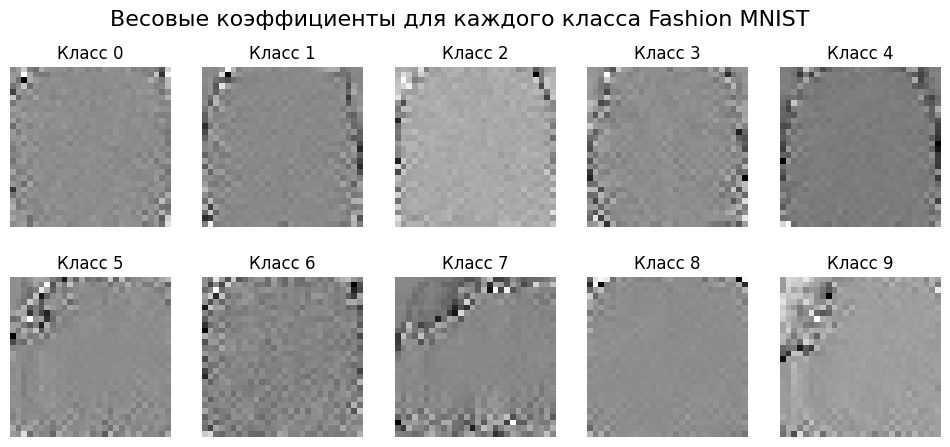

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml

# Загрузка данных Fashion MNIST
fashion_mnist = fetch_openml('Fashion-MNIST')
X, y = fashion_mnist.data, fashion_mnist.target.astype(int)

# Обучение логистической регрессии в режиме One-VS-All
log_reg_model = LogisticRegression(max_iter=1000, multi_class='ovr')
log_reg_model.fit(X, y)

# Получение весов для каждого класса
weights = log_reg_model.coef_

# Визуализация весов как изображений
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Весовые коэффициенты для каждого класса Fashion MNIST", fontsize=16)
for i, ax in enumerate(axes.ravel()):
    weight_image = weights[i].reshape(28, 28)
    ax.imshow(weight_image, cmap='gray')
    ax.set_title(f"Класс {i}")
    ax.axis('off')

plt.show()


Модель выучила графические паттерны в данных. Это видно через очень яркие и очень темные области, подчеркивающие ключевые участки для классификации каждого класса.